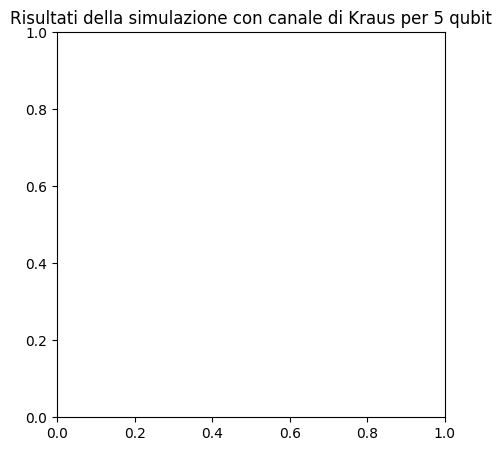

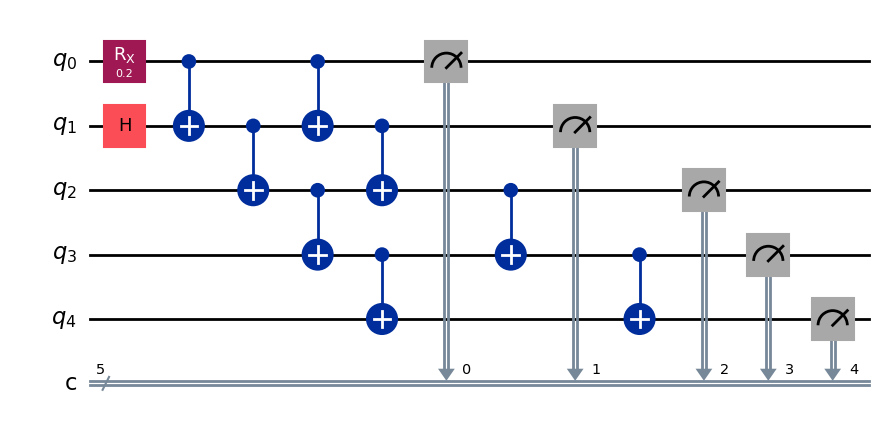

In [172]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display, Latex

# Parametri
n = 5 # Numero di qubit
theta = 0.2
shots = 10000  # Numero di esecuzioni

# Creazione del circuito quantistico
qc = QuantumCircuit(n, n)
qc.rx(theta, 0)
qc.h(1)
qc.cx(0, 1)
for i in range(n - 2):
    qc.cx(i+1, i+2)
    qc.cx(i, i+1)
qc.cx(n-2, n-1)

# Creazione della matrice densità iniziale
rho = DensityMatrix.from_instruction(qc)

# Creazione degli errori (operatori di Kraus)
I = np.eye(2)  # Identità
X = np.array([[0, 1], [1, 0]])  # Pauli-X (Bit-flip)
K0 = np.sqrt(0.9) * I  # Operatore di Kraus K0
K1 = np.sqrt(0.1) * X  # Operatore di Kraus K1

# Espansione degli operatori di Kraus su più qubit
for _ in range(n - 1):
    K0 = np.kron(K0, I)  # Espansione dell'operatore K0 su più qubit
    K1 = np.kron(K1, X)  # Espansione dell'operatore K1 su più qubit

# Applicazione del canale di Kraus alla matrice densità
rho_after_channel = np.sum([K @ rho.data @ K.conj().T for K in [K0, K1]], axis=0)

# Creazione di una nuova DensityMatrix con il risultato
rho_after_channel = DensityMatrix(rho_after_channel)

# Visualizzazione della matrice densità dopo il canale di Kraus in LaTeX
rho_after_channel.draw('latex', prefix='\\rho(\\theta) = ')



# Misura dei qubit
qc.measure(range(n), range(n))

# Simulazione senza rumore (poiché stiamo già simulando il rumore attraverso Kraus)
simulator = Aer.get_backend('aer_simulator')
qc = transpile(qc, simulator)  # Ottimizzazione per il simulatore
result = simulator.run(qc, shots=shots).result()  # Esegui la simulazione

# Ottieni i conteggi dei risultati
counts = result.get_counts()

# Plot dei risultati
plt.figure(figsize=(5, 5))
plot_histogram(counts, color='royalblue')
plt.title(f"Risultati della simulazione con canale di Kraus per {n} qubit")
plt.show()

# Visualizzazione del circuito
qc.draw(output='mpl')

In [100]:
from qiskit_aer.noise import QuantumError, NoiseModel

# 1. Input: numero di qubit e probabilità di rumore
n = 2
p = 0.2

# 2. Genera l'osservabile H
h = 9 / n
d = 2 ** n  # dimensione dello spazio degli stati
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

H_mat = np.zeros((d, d))
for k in range(0, n - 1, 2):
    op = 1
    for qubit in range(n):
        if qubit == k or qubit == k + 1:
            op = np.kron(op, Z)
        else:
            op = np.kron(op, I)
    H_mat += op
H_mat = h * H_mat
print("Osservabile H generato:\n", H_mat)

# 3. Creazione del circuito ansatz semplice
theta = 0.3
qc = QuantumCircuit(n)
for i in range(n):
    qc.rx(theta, i)
for i in range(n - 1):
    qc.cx(i, i + 1)

# 4. Definizione del canale di rumore personalizzato
GHZ = np.zeros((d, 1), dtype=complex)
GHZ[0] = 1 / np.sqrt(2)
GHZ[-1] = 1 / np.sqrt(2)

K1 = np.sqrt(1 - p) * np.eye(d)
K2_list = []
for i in range(d):
    ket_i = np.zeros((d, 1), dtype=complex)
    ket_i[i, 0] = 1.0
    K2 = np.sqrt(p / d) * np.dot(GHZ, ket_i.conj().T)
    K2_list.append(K2)
kraus_ops = [K1] + K2_list

noise_error = QuantumError(kraus_ops)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(noise_error, ['id'])

for i in range(n):
    qc.id(i)

print("\nCircuito ansatz con rumore:")
print(qc.draw())

# 5. Simulazione del circuito con il noise model
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, noise_model=noise_model, shots=1024, parameter_binds=[{theta: 0.5}])
result = job.result()
counts = result.get_counts(qc)
print("\nRisultati della simulazione (counts):", counts)

# (Opzionale) Simulazione dello statevector finale con il noise model
backend_sv = Aer.get_backend('statevector_simulator')
job_sv = execute(qc, backend_sv, noise_model=noise_model, parameter_binds=[{theta: 0.5}])
result_sv = job_sv.result()
statevector = result_sv.get_statevector(qc)
print("\nStatevector finale (con rumore):\n", statevector)


Osservabile H generato:
 [[ 4.5  0.   0.   0. ]
 [ 0.  -4.5  0.   0. ]
 [ 0.   0.  -4.5  0. ]
 [ 0.   0.   0.   4.5]]


NoiseError: "Invalid type of input is found around '[[0.89442719 0.         0.         0.        ]\n [0.         0.89442719 0.         0.        ]\n [0.         0.         0.89442719 0.        ]\n [0.         0.         0.         0.89442719]]'"